In [1]:
import os
import pandas as pd

# Ruta local a históricos
ruta_historicos = "D:/trading/data/historic"

# Leer todos los parquet como {ticker: df}
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df

print(f"Total símbolos cargados: {len(historicos)}")


Total símbolos cargados: 48


In [2]:
# Vista rápida de estructura
for simbolo, df in list(historicos.items())[:5]:
    print(f"{simbolo}: {df.shape} columnas: {list(df.columns)} | fechas: {df['fecha'].min()} → {df['fecha'].max()}")


AAPL: (4999, 6) columnas: ['fecha', 'open', 'high', 'low', 'close', 'volume'] | fechas: 2005-07-18 → 2025-05-29
AMD: (4999, 6) columnas: ['fecha', 'open', 'high', 'low', 'close', 'volume'] | fechas: 2005-07-18 → 2025-05-29
AMZN: (4999, 6) columnas: ['fecha', 'open', 'high', 'low', 'close', 'volume'] | fechas: 2005-07-18 → 2025-05-29
AVGO: (3978, 6) columnas: ['fecha', 'open', 'high', 'low', 'close', 'volume'] | fechas: 2009-08-06 → 2025-05-29
BABA: (2689, 6) columnas: ['fecha', 'open', 'high', 'low', 'close', 'volume'] | fechas: 2014-09-19 → 2025-05-29


In [3]:
import sys
sys.path.append("D:/trading")  # Asegurate de ajustar según estructura real

from my_modules.estrategias.v3 import ema_pullback_v3

# Ejecutar estrategia sobre AAPL
df_signals = ema_pullback_v3.generar_senales(historicos["AAPL"], debug=True)

# Ver señales generadas
df_signals[df_signals["signal"] != "hold"].tail(3)


D:\trading\my_modules\estrategias\v3\ema_pullback_v3.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = df["buy_cond"].shift(1).fillna(False)


,fecha,signal,estrategia,ema_20,tendencia_alcista,pullback,rebote,buy_cond,atr,atr_ratio
4960,2025-04-03,sell,ema_pullback_v3,221.225105,False,True,False,False,7.094152,0.034914
4973,2025-04-23,buy,ema_pullback_v3,202.909876,True,True,True,True,9.991372,0.048834
4974,2025-04-24,sell,ema_pullback_v3,203.429888,True,False,True,False,9.698417,0.046544


In [4]:
import importlib
import inspect

# Ruta al módulo donde están las estrategias v3
modulo_base = "my_modules.estrategias.v3"

# Estrategias a ejecutar (archivos sin .py)
estrategias_v3 = [
    "adx_filter_trend_v3", "bollinger_breakout_v3", "breakout_volumen_v3",
    "cruce_medias_v3", "ema_9_21_cruce_v3", "ema_pullback_v3", "gap_open_strategy_v3",
    "ma_envelope_reversals_v3", "macd_cruce_v3", "macd_hist_reversal_v3",
    "mov_avg_v3", "rsi_divergencia_v3", "rsi_reversion_v3",
    "sma_10_50_cruce_v3", "soporte_resistencia_v3"
]

# Almacenar resultados
senales_totales = []

for nombre_estrategia in estrategias_v3:
    try:
        modulo = importlib.import_module(f"{modulo_base}.{nombre_estrategia}")
        funcion = getattr(modulo, "generar_senales")
        
        for simbolo, df in historicos.items():
            df_resultado = funcion(df, debug=False)
            df_resultado["ticker"] = simbolo
            senales_filtradas = df_resultado[df_resultado["signal"] != "hold"]
            if not senales_filtradas.empty:
                senales_totales.append(senales_filtradas)

    except Exception as e:
        print(f"⚠️ Error en {nombre_estrategia}: {e}")


D:\trading\my_modules\estrategias\v3\ema_pullback_v3.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = df["buy_cond"].shift(1).fillna(False)
D:\trading\my_modules\estrategias\v3\ema_pullback_v3.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["prev_buy"] = df["buy_cond"].shift(1).fillna(False)
D:\trading\my_modules\estrategias\v3\ema_pullback_v3.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt

In [5]:
df_senales = pd.concat(senales_totales, ignore_index=True)
print(f"Total señales generadas: {len(df_senales)}")
df_senales.sample(10)


Total señales generadas: 416523


,fecha,signal,estrategia,ticker
226212,2013-01-31,buy,ema_9_21_cruce_v3,META
167822,2014-11-21,buy,ema_9_21_cruce_v3,BAC
285479,2023-07-12,buy,ema_9_21_cruce_v3,TSM
339846,2025-01-17,sell,ma_envelope_reversals_v3,EXE
16094,2019-09-17,buy,adx_filter_trend_v3,BAC
46759,2017-07-19,buy,adx_filter_trend_v3,JPM
350968,2006-04-06,sell,ma_envelope_reversals_v3,SKX
219171,2016-09-19,sell,ema_9_21_cruce_v3,KHC
403765,2013-04-15,buy,sma_10_50_cruce_v3,NVDA
312287,2010-12-07,buy,ema_pullback_v3,GOOGL


In [6]:
df_senales.groupby("estrategia")["signal"].value_counts().unstack(fill_value=0)


signal,buy,sell
estrategia,,
adx_filter_trend_v3,57516,44884
bollinger_breakout_v3,14501,13785
breakout_volumen_v3,12764,9602
cruce_medias_v3,1868,1158
ema_9_21_cruce_v3,92907,67974
ema_pullback_v3,11100,8863
gap_open_strategy_v3,3183,2874
ma_envelope_reversals_v3,11097,15065
macd_cruce_v3,6733,6737


In [7]:
df_senales = pd.concat(senales_totales, ignore_index=True)
print(f"Total señales generadas: {len(df_senales)}")
df_senales.sample(10)


Total señales generadas: 416523


,fecha,signal,estrategia,ticker
388019,2019-09-25,buy,mov_avg_v3,ORCL
65009,2009-04-17,buy,adx_filter_trend_v3,NVDA
388682,2015-03-11,sell,mov_avg_v3,SKX
390999,2023-01-09,buy,mov_avg_v3,WMT
50211,2010-08-24,sell,adx_filter_trend_v3,LLY
357685,2017-01-13,buy,ma_envelope_reversals_v3,XOM
28553,2016-02-10,sell,adx_filter_trend_v3,EQR
180414,2021-08-02,buy,ema_9_21_cruce_v3,DGX
329957,2020-04-22,buy,gap_open_strategy_v3,PFE
251878,2014-03-04,buy,ema_9_21_cruce_v3,ORCL


In [8]:
df_senales.groupby("estrategia")["signal"].value_counts().unstack(fill_value=0)


signal,buy,sell
estrategia,,
adx_filter_trend_v3,57516,44884
bollinger_breakout_v3,14501,13785
breakout_volumen_v3,12764,9602
cruce_medias_v3,1868,1158
ema_9_21_cruce_v3,92907,67974
ema_pullback_v3,11100,8863
gap_open_strategy_v3,3183,2874
ma_envelope_reversals_v3,11097,15065
macd_cruce_v3,6733,6737


In [9]:
df_senales.groupby("ticker")["signal"].value_counts().unstack(fill_value=0).sort_values("buy", ascending=False)


signal,buy,sell
ticker,,
AAPL,7531,5527
NVDA,7431,5551
AMZN,7404,5392
CRM,7102,5509
MSFT,7062,5123
GOOGL,7042,5573
TMO,6929,4973
AMD,6818,6388
TSM,6773,5210


In [10]:
ruta_salida = "D:/trading/reports/backtest_heuristicas/v3_senales_raw.csv"
df_senales.to_csv(ruta_salida, index=False)


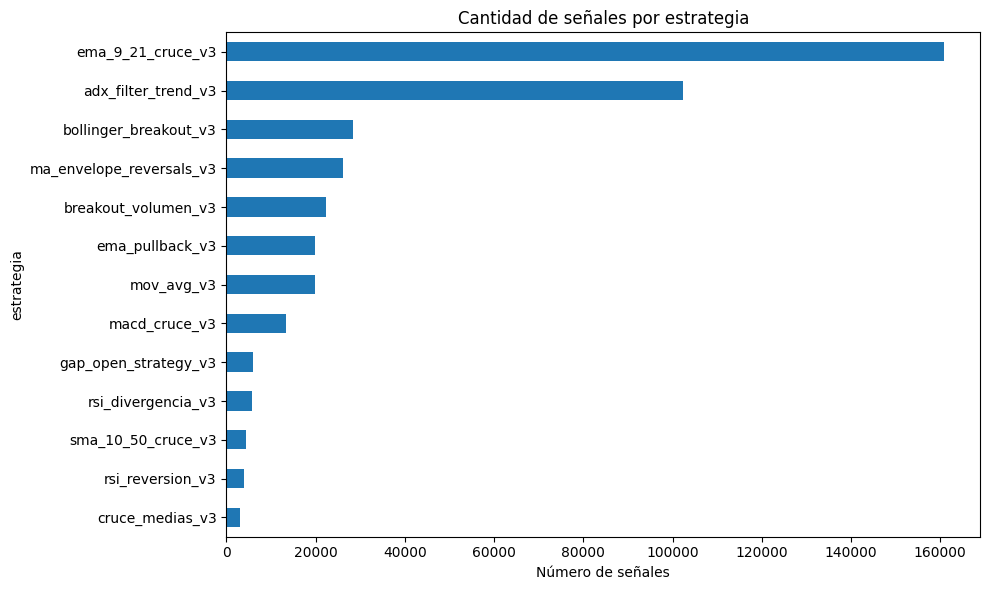

In [11]:
import matplotlib.pyplot as plt

estrategia_counts = df_senales["estrategia"].value_counts()

plt.figure(figsize=(10,6))
estrategia_counts.plot(kind="barh")
plt.title("Cantidad de señales por estrategia")
plt.xlabel("Número de señales")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


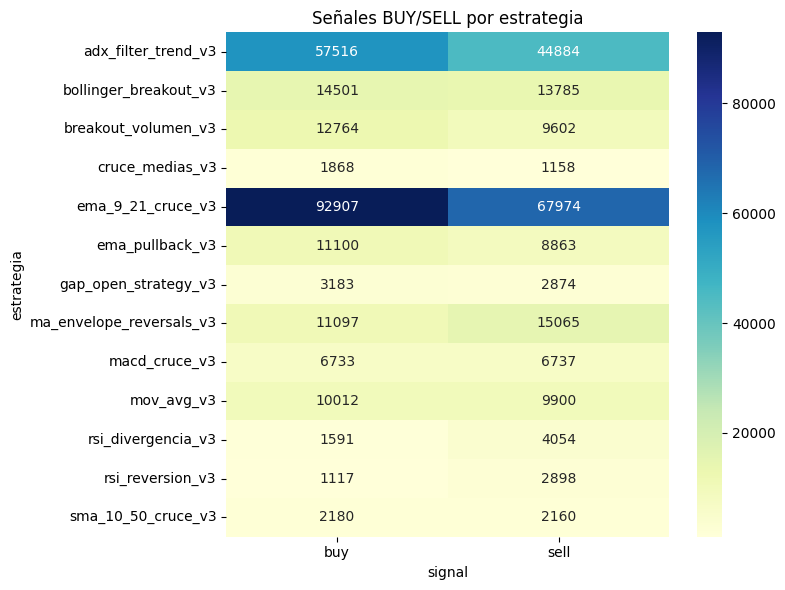

In [12]:
import seaborn as sns

pivot_estrategia = df_senales.pivot_table(index="estrategia", columns="signal", values="fecha", aggfunc="count", fill_value=0)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_estrategia, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Señales BUY/SELL por estrategia")
plt.tight_layout()
plt.show()


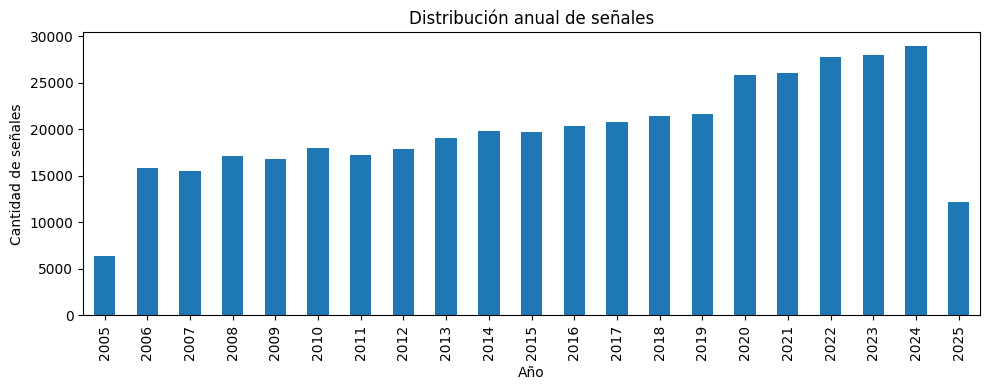

In [13]:
df_senales["año"] = pd.to_datetime(df_senales["fecha"]).dt.year

df_senales["año"].value_counts().sort_index().plot(kind="bar", figsize=(10,4))
plt.title("Distribución anual de señales")
plt.xlabel("Año")
plt.ylabel("Cantidad de señales")
plt.tight_layout()
plt.show()


In [14]:
def procesar_ticker(ticker, df_signals, df_precio, tp=0.05, sl=0.03, max_dias=7):
    from datetime import timedelta
    import numpy as np
    import pandas as pd

    resultados = []

    if not pd.api.types.is_datetime64_any_dtype(df_precio["fecha"]):
        df_precio = df_precio.copy()
        df_precio["fecha"] = pd.to_datetime(df_precio["fecha"])

    for idx, row in df_signals.iterrows():
        fecha_entrada = pd.Timestamp(row["fecha"])
        df_post = df_precio[df_precio["fecha"] >= fecha_entrada]

        if df_post.empty:
            continue

        fila_entrada = df_post.iloc[0]
        precio_entrada = fila_entrada["close"]
        fecha_real_entrada = fila_entrada["fecha"]

        fecha_limite = fecha_real_entrada + timedelta(days=max_dias)
        df_rango = df_post[(df_post["fecha"] > fecha_real_entrada) & (df_post["fecha"] <= fecha_limite)]

        if df_rango.empty:
            continue

        tipo_salida = "TIMEOUT"
        fila_salida = df_rango.iloc[-1]

        for _, f in df_rango.iterrows():
            if row["signal"] == "buy":
                if f["high"] >= precio_entrada * (1 + tp):
                    tipo_salida = "TP"; fila_salida = f; break
                if f["low"] <= precio_entrada * (1 - sl):
                    tipo_salida = "SL"; fila_salida = f; break
            elif row["signal"] == "sell":
                if f["low"] <= precio_entrada * (1 - tp):
                    tipo_salida = "TP"; fila_salida = f; break
                if f["high"] >= precio_entrada * (1 + sl):
                    tipo_salida = "SL"; fila_salida = f; break

        precio_salida = fila_salida["close"]
        fecha_salida = fila_salida["fecha"]
        dias = (fecha_salida - fecha_entrada).days

        resultado_neto = precio_salida - precio_entrada if row["signal"] == "buy" else precio_entrada - precio_salida
        ret_pct = (precio_salida / precio_entrada - 1) * (1 if row["signal"] == "buy" else -1)
        log_ret = np.log(precio_salida / precio_entrada) * (1 if row["signal"] == "buy" else -1)

        resultados.append({
            "id_orden": idx,
            "fecha_entrada": row["fecha"],
            "fecha_salida": fecha_salida,
            "dias": dias,
            "precio_entrada": precio_entrada,
            "precio_salida": precio_salida,
            "estrategia": row["estrategia"],
            "signal": row["signal"],
            "ticker": ticker,
            "tipo_salida": tipo_salida,
            "resultado": resultado_neto,
            "resultado_pct": ret_pct,
            "log_ret": log_ret,
            "f_win": int(resultado_neto > 0),
            "comision": 0.6
        })

    return resultados


In [15]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Agrupar señales por ticker
tickers_con_signales = df_senales["ticker"].unique()
bloques = []

for ticker in tickers_con_signales:
    if ticker in historicos:
        df_ticker = df_senales[df_senales["ticker"] == ticker]
        bloques.append((ticker, df_ticker, historicos[ticker]))

# Ejecutar por símbolo en paralelo
resultados = Parallel(n_jobs=-1)(
    delayed(procesar_ticker)(ticker, df_signals, df_precio)
    for ticker, df_signals, df_precio in tqdm(bloques)
)

# Aplanar la lista de listas
from itertools import chain
resultados = list(chain.from_iterable(resultados))

# Consolidar
df_operaciones = pd.DataFrame(resultados)
df_operaciones["resultado"] -= df_operaciones["comision"]

print(f"✅ Total operaciones simuladas: {len(df_operaciones)}")
df_operaciones.sample(5)



100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [02:56<00:00,  3.68s/it]


✅ Total operaciones simuladas: 416363


,id_orden,fecha_entrada,fecha_salida,dias,precio_entrada,precio_salida,estrategia,signal,ticker,tipo_salida,resultado,resultado_pct,log_ret,f_win,comision
69514,18625,2016-03-16,2016-03-23,7,72.7300,71.780,adx_filter_trend_v3,buy,CRM,TIMEOUT,-1.5500,-0.013062,-0.013148,0,0.6
292862,258541,2022-01-21,2022-01-24,3,52.7900,51.540,ema_9_21_cruce_v3,sell,PFE,TP,0.6500,0.023679,0.023964,1,0.6
79463,382905,2009-01-13,2009-01-14,1,7.4075,6.965,mov_avg_v3,sell,CRM,TP,-0.1575,0.059737,0.061595,1,0.6
277434,250474,2008-04-24,2008-04-25,1,22.0100,21.590,ema_9_21_cruce_v3,buy,ORCL,SL,-1.0200,-0.019082,-0.019267,0,0.6
88506,176815,2006-08-24,2006-08-31,7,63.5500,64.280,ema_9_21_cruce_v3,buy,DGX,TIMEOUT,0.1300,0.011487,0.011422,1,0.6


In [16]:
resumen = df_operaciones.groupby("estrategia").agg({
    "resultado": ["sum", "mean", "count"],
    "f_win": "mean",
    "dias": "mean",
    "log_ret": "mean"
})

# Renombrar columnas
resumen.columns = ["total_profit", "avg_profit", "n_trades", "winrate", "avg_duracion", "avg_logret"]

# Agregar score: una métrica simple = avg_profit * winrate
resumen["score"] = resumen["avg_profit"] * resumen["winrate"]

# Ordenar por score
resumen = resumen.sort_values("score", ascending=False)

resumen.round(4)


,total_profit,avg_profit,n_trades,winrate,avg_duracion,avg_logret,score
estrategia,,,,,,,
cruce_medias_v3,-1185.8516,-0.3919,3026,0.5109,5.2634,0.0028,-0.2002
sma_10_50_cruce_v3,-2285.2278,-0.5266,4340,0.4859,5.2069,0.0016,-0.2559
mov_avg_v3,-11047.9410,-0.5549,19910,0.4795,5.1934,0.0010,-0.2660
ema_pullback_v3,-11166.5805,-0.5594,19961,0.4818,5.7150,0.0005,-0.2696
macd_cruce_v3,-7677.6667,-0.5702,13465,0.4753,5.2007,0.0007,-0.2710
bollinger_breakout_v3,-16778.2385,-0.5933,28279,0.4663,4.7984,0.0001,-0.2767
ema_9_21_cruce_v3,-94988.5929,-0.5907,160814,0.4698,5.1666,0.0001,-0.2775
adx_filter_trend_v3,-63831.6287,-0.6236,102365,0.4628,5.1141,-0.0004,-0.2886
rsi_divergencia_v3,-3548.3817,-0.6289,5642,0.4624,5.1827,-0.0010,-0.2908


In [17]:
resumen.to_csv("D:/trading/reports/backtest_heuristicas/summary_v3.csv")
df_operaciones.to_csv("D:/trading/reports/backtest_heuristicas/bt_operaciones_v3.csv", index=False)


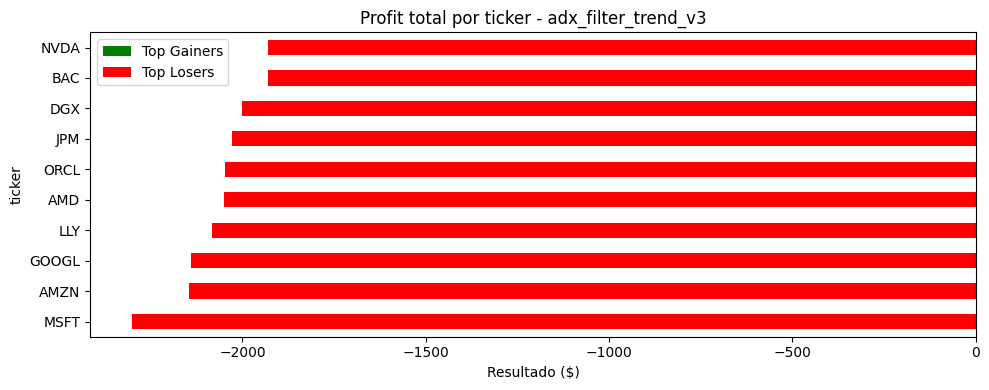

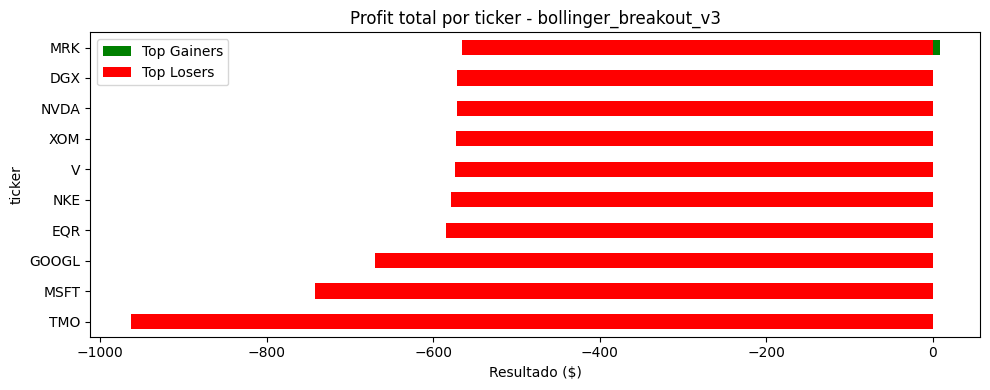

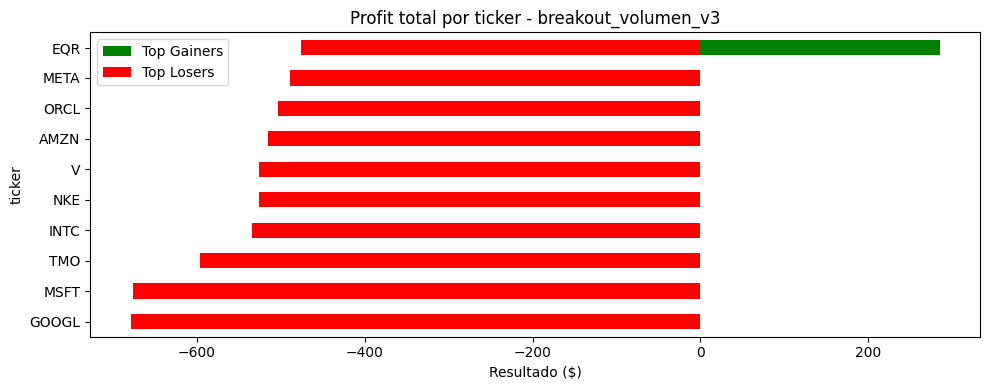

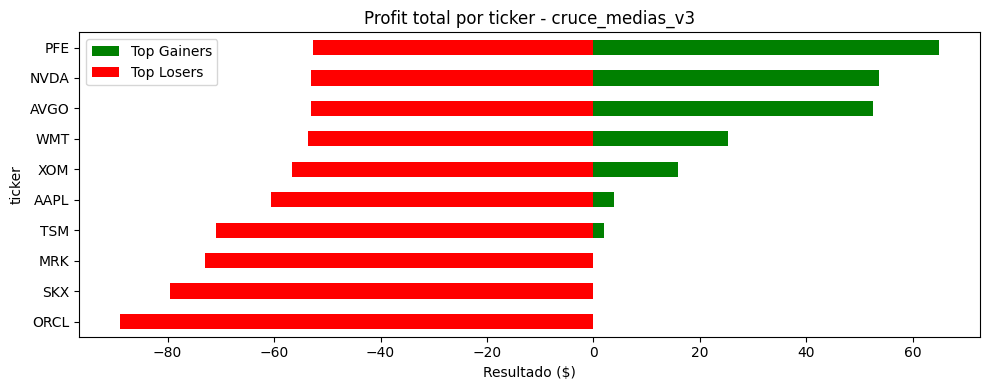

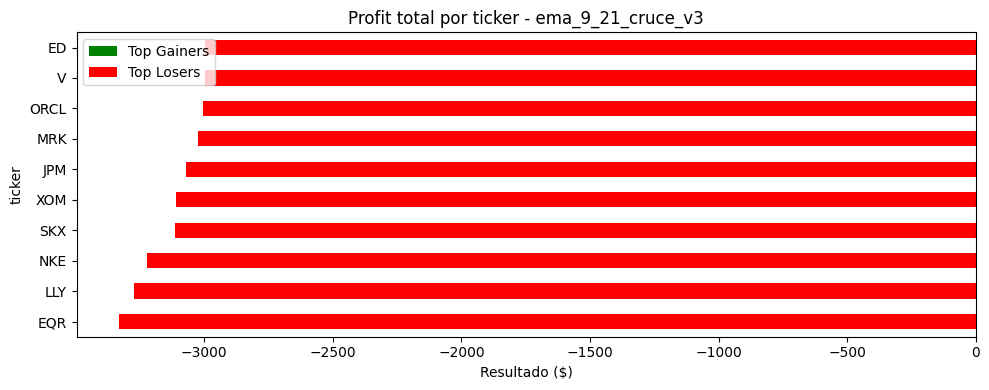

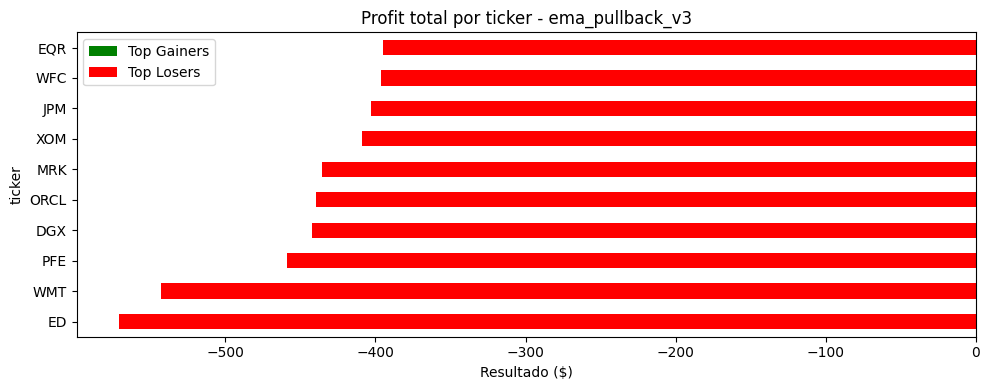

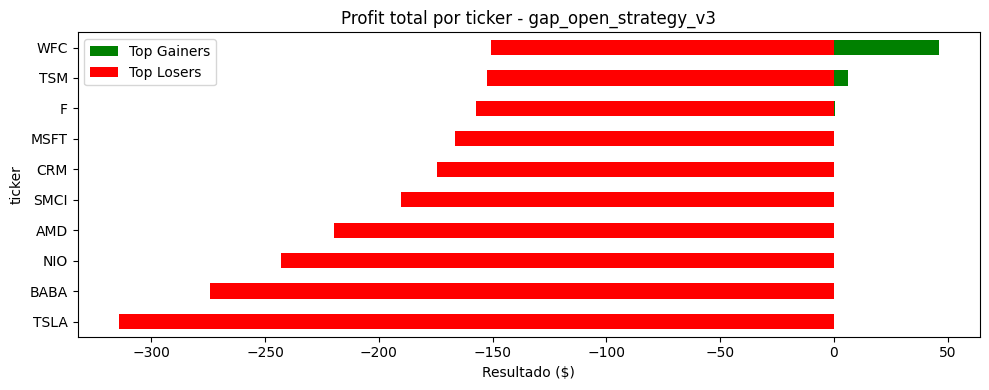

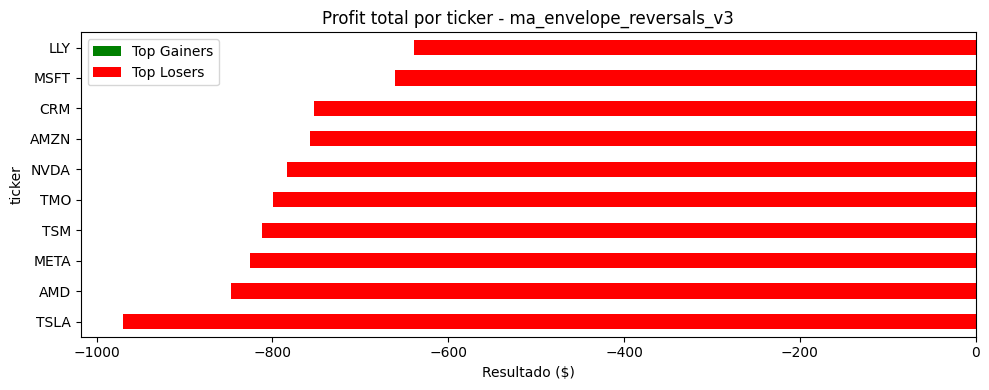

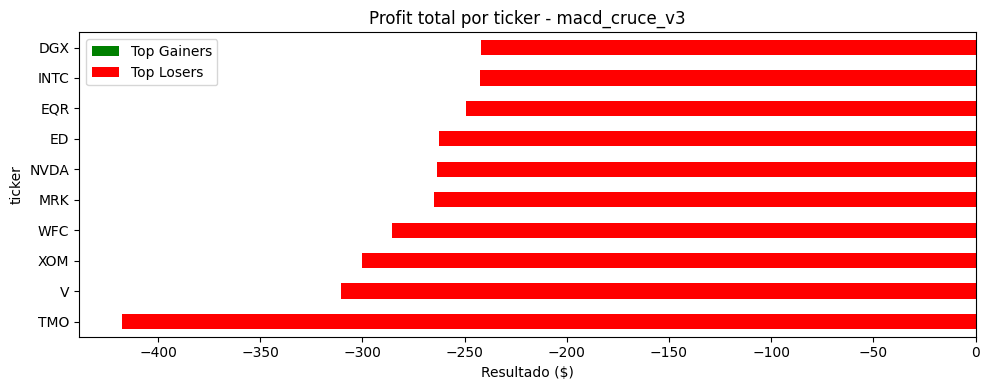

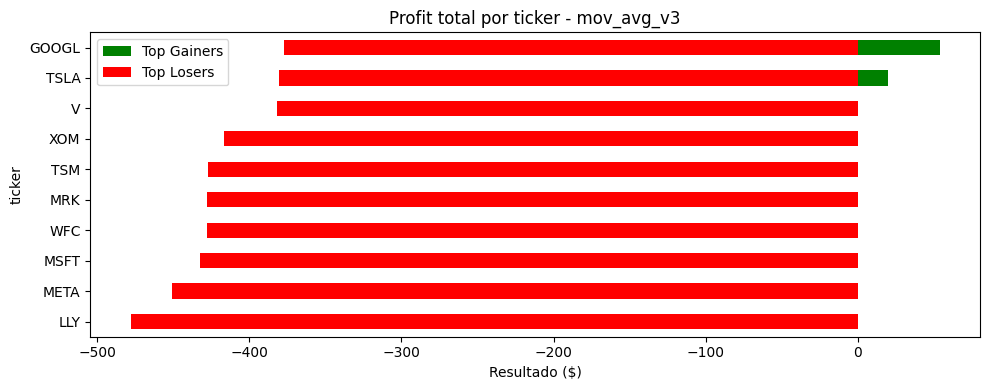

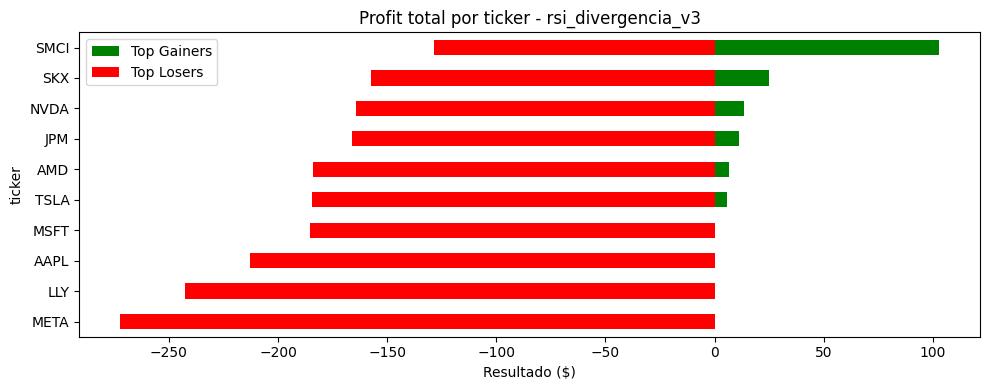

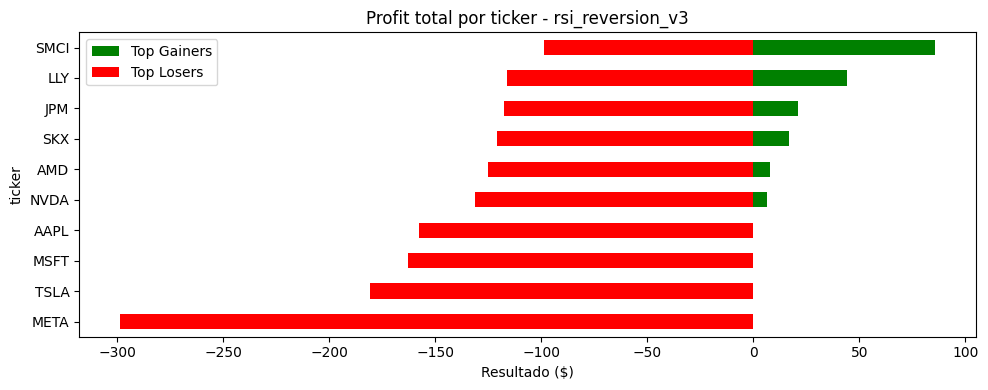

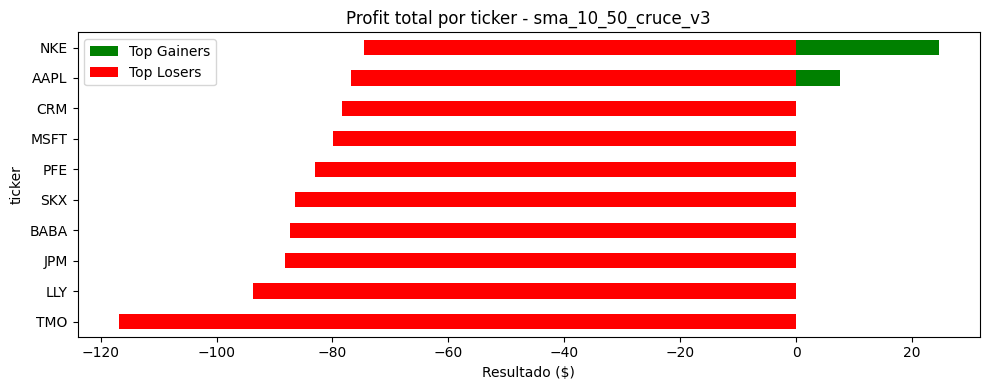

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 10  # top N tickers por estrategia

estrategias = df_operaciones["estrategia"].unique()

for est in estrategias:
    df_sub = df_operaciones[df_operaciones["estrategia"] == est]
    resumen = df_sub.groupby("ticker")["resultado"].sum().sort_values()
    
    plt.figure(figsize=(10, 4))
    resumen.tail(top_n).plot(kind="barh", color="green", label="Top Gainers")
    resumen.head(top_n).plot(kind="barh", color="red", label="Top Losers")
    plt.title(f"Profit total por ticker - {est}")
    plt.xlabel("Resultado ($)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [25]:
resumen = df_operaciones.groupby("estrategia").agg({
    "resultado": ["sum", "mean", "count"],
    "f_win": "mean",
    "dias": "mean",
    "log_ret": "mean"
})

# Eliminar columnas multi-index
resumen.columns = ["total_profit", "avg_profit", "n_trades", "winrate", "avg_duracion", "avg_logret"]

# Agregar score y reordenar
resumen["score"] = resumen["avg_profit"] * resumen["winrate"]
resumen = resumen.sort_values("score", ascending=False)

# Asegurar que estrategia sea columna
resumen_plot = resumen.reset_index()



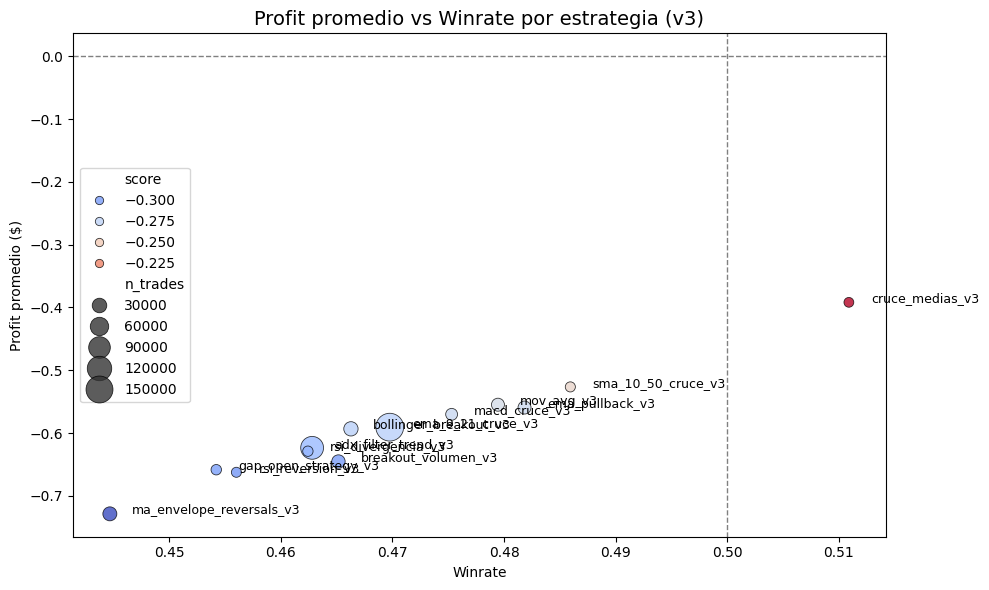

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que resumen tenga el índice como columna
resumen_plot = resumen.reset_index()  # 'estrategia' pasa a columna

plt.figure(figsize=(10, 6))

# Graficar scatter
sns.scatterplot(
    data=resumen_plot,
    x="winrate", 
    y="avg_profit", 
    size="n_trades", 
    hue="score", 
    palette="coolwarm", 
    sizes=(50, 400),
    alpha=0.8,
    edgecolor="black"
)

# Anotar cada punto con el nombre de la estrategia
for _, fila in resumen_plot.iterrows():
    plt.text(fila["winrate"] + 0.002, fila["avg_profit"], fila["estrategia"], fontsize=9)

# Líneas de referencia
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0.5, color="gray", linestyle="--", linewidth=1)

plt.title("Profit promedio vs Winrate por estrategia (v3)", fontsize=14)
plt.xlabel("Winrate")
plt.ylabel("Profit promedio ($)")
plt.tight_layout()
plt.show()


